# Problem Statement

This project seeks to identify the best classification model that can distinguish which of two subreddits a post belongs to. The  performance of 2 parametric models will be evaluated. In the instance of Logistic Regression, the coefficients can be interpreted to identify features that increases the log-odds of a post to be from the positive class, or else being equal.

Advertisors seeking to use reddit as a marketing platform will be able to develop marketing strategies specifically targeted  at each subreddit based on what each community is most concerned about.

Two closely-related subreddits, namely /gainit and /keto are selected to identify the classification model that can more accurately classify the posts to their respective subreddit. 

The /gainit subreddit is a fitness subreddit for information and discussion for people looking to put on weight, muscle, and strength.

The /keto subreddit is a place to share thoughts, ideas, benefits, and experiences around eating within a Ketogenic lifestyle.

While seemingly dissimilar, the 2 threads share commonalities. 
1. Focus on caloric intake and fitness
2. Macronutrients: The basis of a ketogenic diet is one that focuses on a relatively high-protein, high-fat diet. The increased intake amount of these nutrients are common to what a person seeking to gain muscle/weight would incorporate to attain the one's goal

Moderators of the post can use the model to potentially flag out misclassified posts to maintain the integrity of the posts in the subreddit thread.  

## Executive Summary


### Contents:
- [Data Import](#Data-Import)
- [Cleaning](#Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Model Prep](#Model-Prep)
- [Model fit and evaluation](#Model-fit-and-evaluation)
- [Business Recommendations](#Business-Recommendations)

In [1]:
import sys
print(sys.executable)

/Users/jocelynpok/opt/anaconda3/bin/python


In [2]:
!/Users/jocelynpok/opt/anaconda3/bin/python -m pip install wordcloud

## Data Import

In [3]:
#imports:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import re
import time
import datetime as dt
import random
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,roc_auc_score,classification_report
from sklearn.naive_bayes import MultinomialNB 

sns.set()
%matplotlib inline

In [4]:
keto_df = pd.read_csv('../datasets/keto.csv')
keto_df.shape

(5290, 109)

In [5]:
keto_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Columns: 109 entries, approved_at_utc to author_cakeday
dtypes: bool(26), float64(25), int64(10), object(48)
memory usage: 3.5+ MB


In [6]:
gainIt_df = pd.read_csv('../datasets/gainit.csv')
gainIt_df.shape[0]

5290

In [7]:
keto_filtered_df = keto_df.loc[:,['selftext']]
keto_filtered_df['target'] = 1

In [8]:
gainIt_filtered_df = gainIt_df.loc[:,['selftext']]
gainIt_filtered_df['target'] = 0

The /gainit and /keto subreddit posts are combined into a single dataframe. The dataset has 10580 rows and 2 columns, with the target column of int type and selftext of object type. The dataset is incomplete with selftext column containing null values.

Approximately half of the dataset are found to be duplicates and they are subsequently dropped. 

Null values occured in the 'selftext' column, and this occurs when the reddit user decides only to use the title field. The null values are filled with arbitrary text to avoid potentially losing invaluable information. The final cleaned dataset had 995 documents and 2 features. The target feature is mapped according to the subreddit class that the posts belong to. 1 for those belonging to the /keto subreddit and 0 for those belonging to the /gainit subreddit. The target has a balance of classes of approximately 50% for both class 1 and 0.

In [9]:
combined_df = pd.concat([keto_filtered_df,gainIt_filtered_df], ignore_index=True)
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10580 entries, 0 to 10579
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   selftext  10320 non-null  object
 1   target    10580 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 165.4+ KB


In [10]:
combined_df.shape

(10580, 2)

## Cleaning

In [11]:
combined_df.drop_duplicates(keep='first', inplace=True)

In [12]:
combined_df.shape

(960, 2)

In [13]:
combined_df.isnull().sum()

selftext    2
target      0
dtype: int64

In [14]:
combined_df.fillna('missingtext', inplace=True)

In [15]:
combined_df.target.value_counts(normalize=True)

1    0.515625
0    0.484375
Name: target, dtype: float64

In [16]:
combined_df.to_csv('../datasets/combined.csv')

Data cleaning is done by 

1. Removing text that corresponding to custom regex patterns that includes one that identifies url  
2. To prevent data leakage, the subreddit topic is also removed. 
3. After obtaining only letters from the previous steps, the text is converted to lowercase and split into individual words.
4. Stopwords are removed

The function text_to_words is created for this purpose.

In [17]:
#Searching a set is much faster than searching
# a list, so convert the stopwords to a set.
stops = set(stopwords.words('english'))

In [18]:

def text_to_words(raw):
    # Function to convert a raw selftext to a string of words
    # The input is a single string (a raw selftext), and 
    # the output is a single string (a preprocessed selftext)
    
    # 1. Creation of regex patterns. Remove text that correspond to regex patterns
    #pattern_1 = '\[(.*?)\]' #square brackets
    pattern_2 = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})' #urls
    pattern_3 = 'keto' #subreddit(prevent data leakage)
    pattern_4 = '\/r\/' #indicative of subreddit
    pattern_5 = 'gainit'
    generic_re = re.compile("(%s|%s)" % (pattern_2, pattern_4))
    raw_no_data_leakage = re.sub(r'keto', r' ', raw)
    raw_no_data_leakage_2 = re.sub(r'gainit', r' ', raw_no_data_leakage)
    raw_text = re.sub(generic_re, r' ', raw_no_data_leakage_2)
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", raw_text)
   
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4.  Remove leakage terms
    words = [w for w in words if pattern_3 not in w and pattern_5 not in w]
    
    
    # 4. Remove stopwords.
    
    meaningful_words = [w for w in words if not w in stops]
    
    
    # 5. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

## Exploratory Data Analysis

To explore how the frequency and commonality of words across the 2 subreddits can affect the model, a word cloud containing 100 words from the selftext of both subreddits are created. High frequency features like 'diet','eat','day' appear in /keto subreddits while terms like 'weight' and 'lb' appear in the /gainit subreddit posts.

In [19]:
#keto selftext
target_1_selftext_df = combined_df.loc[(combined_df['target']==1),['selftext']]
#gainit selftext
target_0_selftext_df = combined_df.loc[(combined_df['target']==0),['selftext']]

In [20]:
total_selftext = combined_df.shape[0]
combined_df['word_count_selftext'] = np.nan
clean_selftext = ' '
print("Cleaning and parsing the selftext...")

# Instantiate counter.
j = 0

for selftext in combined_df['selftext']:
    
    # Convert review to words, then append to clean_train_selftext.
    #clean_title.append(selftext_to_words(title))
    clean_selftext = clean_selftext + text_to_words(selftext) + ' '
    combined_df['word_count_selftext'].values[j] = len(text_to_words(selftext).split())
    
    # If the index is divisible by 100, print a message.
    if (j + 1) % 100 == 0:
        print(f'Title {j + 1} of {total_selftext}.')
    
    j += 1

Cleaning and parsing the selftext...
Title 100 of 960.
Title 200 of 960.
Title 300 of 960.
Title 400 of 960.
Title 500 of 960.
Title 600 of 960.
Title 700 of 960.
Title 800 of 960.
Title 900 of 960.


In [21]:
total_selftext_1 = target_1_selftext_df.shape[0]
total_selftext_1


495

In [22]:
total_selftext_0 = target_0_selftext_df.shape[0]
total_selftext_0

465

In [23]:
clean_selftext_target1_str = ' '
clean_selftext_target0_str = ' '
clean_selftext_target1 = []
clean_selftext_target0 = []
print("Cleaning and parsing the selftext...")

# Instantiate counter.
j = 0
i = 0
# For every selftext in our target 1...
for selftext in target_1_selftext_df['selftext']:
    
    clean_selftext_target1_str = clean_selftext_target1_str + text_to_words(selftext) + ' '
    # Convert review to words, then append to clean_train_selftext.
    clean_selftext_target1.append(text_to_words(selftext))
    
    # If the index is divisible by 100, print a message.
    if (j + 1) % 100 == 0:
        print(f'Review {j + 1} of {total_selftext_1}.')
    
    j += 1
# For every selftext in our target 0...
for selftext in target_0_selftext_df['selftext']:
    
    clean_selftext_target0_str = clean_selftext_target0_str + text_to_words(selftext) + ' '
    # Convert review to words, then append to clean_train_selftext.
    clean_selftext_target0.append(text_to_words(selftext))
    
    # If the index is divisible by 100, print a message.
    if (i + 1) % 100 == 0:
        print(f'Review {i + 1} of {total_selftext_0}.')
    
    i += 1

Cleaning and parsing the selftext...
Review 100 of 495.
Review 200 of 495.
Review 300 of 495.
Review 400 of 495.
Review 100 of 465.
Review 200 of 465.
Review 300 of 465.
Review 400 of 465.


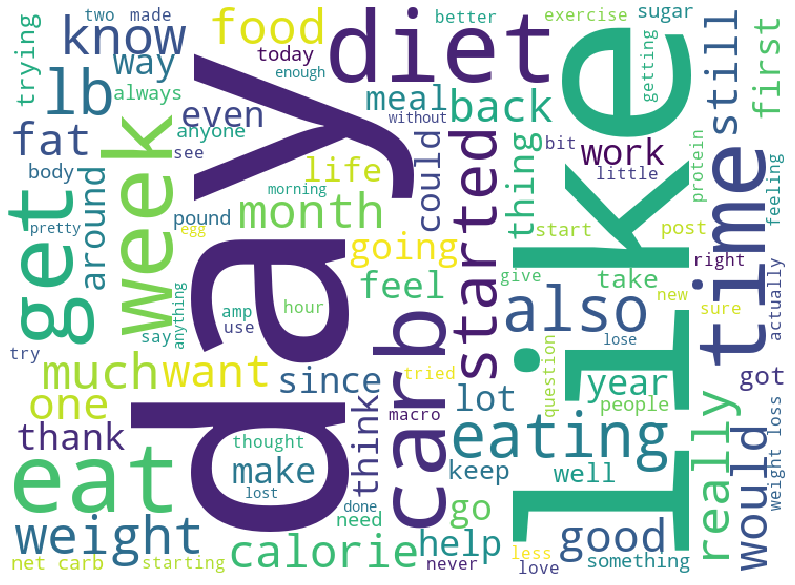

In [24]:
# WordCloud generated from keto parsed words 
wc = WordCloud(max_words= 100,
                      width = 744, 
                      height = 544,
                      background_color ='white',
                      stopwords=stops, 
                      contour_width=3, 
                      contour_color='steelblue',
                      min_font_size = 10).generate(clean_selftext_target1_str) 
  
# plot the WordCloud image                        
plt.figure(figsize = (14, 14)) 
plt.imshow(wc) 
plt.axis("off")
plt.savefig('../images/reddit_wordcloud_selftext_keto.png')

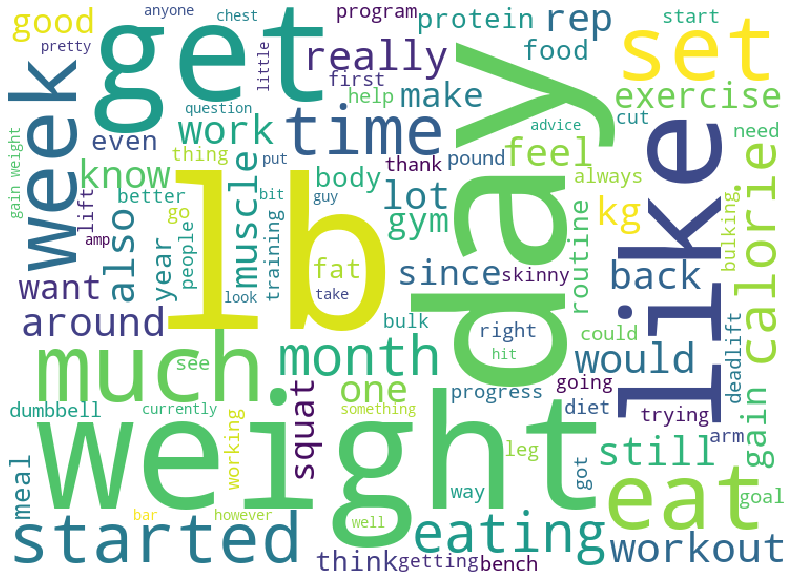

In [25]:
# WordCloud generated from gainit parsed words 
wc2 = WordCloud(max_words= 100,
                      width = 744, 
                      height = 544,
                      background_color ='white',
                      stopwords=stops, 
                      contour_width=3, 
                      contour_color='steelblue',
                      min_font_size = 10).generate(clean_selftext_target0_str) 
  
# plot the WordCloud image                        
plt.figure(figsize = (14, 14)) 
plt.imshow(wc2) 
plt.axis("off")
plt.savefig('../images/reddit_wordcloud_selftext_gainit.png')

The mean was found to be greater than the median for both of the distribution of word count for the posts in both subreddits, indicating that both distribution are positively skewed

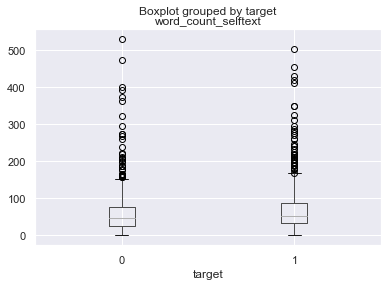

In [26]:
combined_df.boxplot(column='word_count_selftext', by='target');

In [27]:
df_1_word_count = combined_df.loc[(combined_df['target']==1),['word_count_selftext']]
df_1_word_count.describe()

,word_count_selftext
count,495.000000
mean,73.963636
std,68.858820
min,1.000000
25%,33.500000
50%,52.000000
75%,87.000000
max,503.000000


In [28]:
df_0_word_count = combined_df.loc[(combined_df['target']==0),['word_count_selftext']]
df_0_word_count.describe()

,word_count_selftext
count,465.000000
mean,64.010753
std,65.924868
min,0.000000
25%,25.000000
50%,46.000000
75%,76.000000
max,529.000000


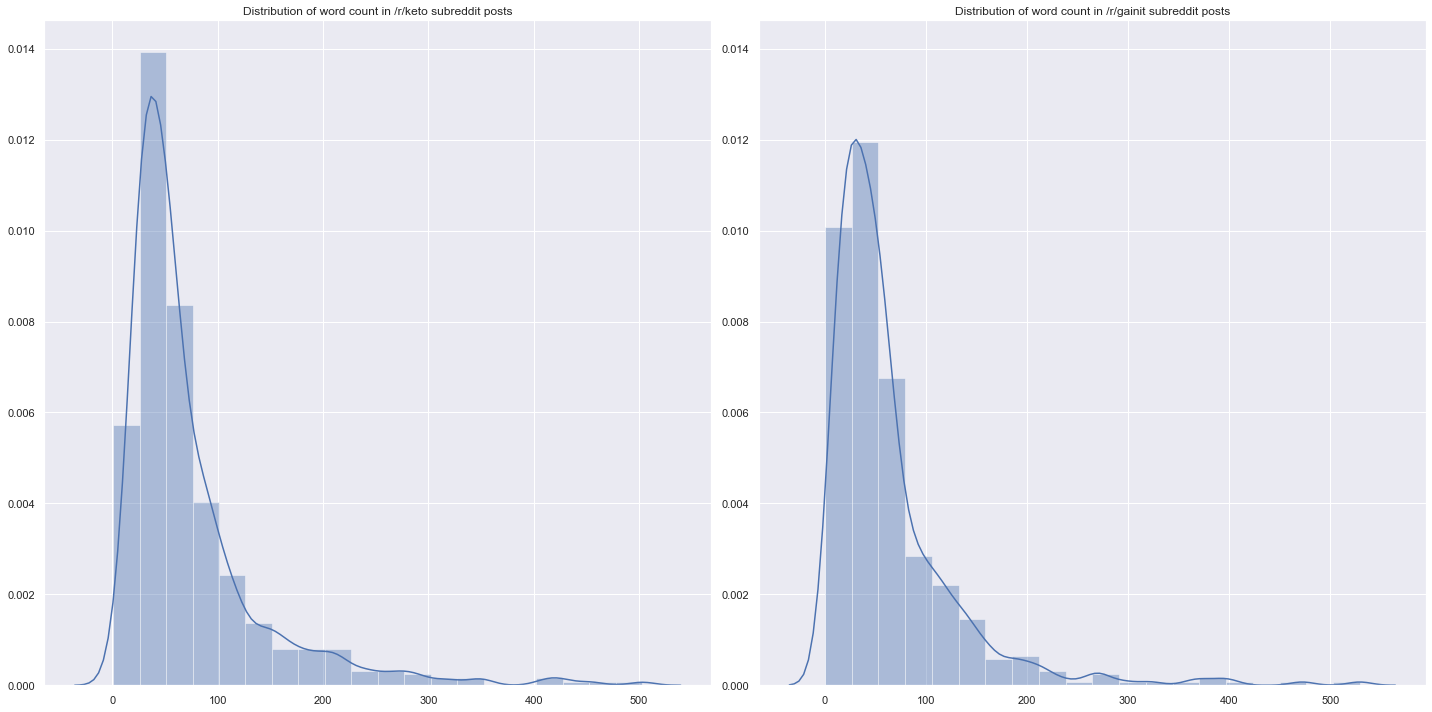

In [29]:
def distplot_wordcount():
    f = plt.figure(figsize=(20, 10))
    nrows = 1
    gs = f.add_gridspec(nrows, 2)

    with sns.axes_style("darkgrid"):
        ax = f.add_subplot(gs[0, 0])
        #sns.set(font_scale=2.5)
        sns.distplot(combined_df.loc[(combined_df['target']==1),['word_count_selftext']], kde=True, color="b", ax=ax, bins=20).set_title('Distribution of word count in /r/keto subreddit posts')

    with sns.axes_style("darkgrid"):
        ax1 = f.add_subplot(gs[0, 1],sharey=ax)
        #sns.set(font_scale=2.5)
        sns.distplot(combined_df.loc[(combined_df['target']==0),['word_count_selftext']], kde=True, color="b", ax=ax1,bins=20).set_title('Distribution of word count in /r/gainit subreddit posts')

    f.tight_layout()
distplot_wordcount()

Using the CountVectorizer, the top 5 unigrams that appear in keto subreddit are “weight”, “like”, day”, “carbs”, and “diet”.
The top 5 unigrams that appear in gainit subreddit are “weight”, “day”, “lbs”, “calories”, and “like”.

The top 5 bigrams that appear in keto subreddit are “weight loss”, “net carbs”, low carb”, “feel like”, and “lose weight”.
The top 5 unigrams that appear in gainit subreddit are “gain weight”, “bench press”, “pull ups”, “feel like”, and “push ups”.

There appears to be a greater emphasis of incorporation of a fitness routine in the /gainit subreddit post

In [30]:
def get_top_n_words(corpus, n=None):
    # Function to get top n words from corpus
    
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


weight 366
like 317
day 299
carbs 268
diet 232
time 226
lbs 214
eat 208
eating 207
get 201
would 191
feel 188
fat 188
started 186
know 185
also 183
much 180
days 162
really 162
back 160


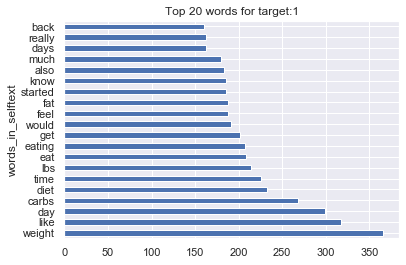

In [31]:
# display top words and corresponding frequecy for target 1
common_words_1 = get_top_n_words(clean_selftext_target1, 20)
for word, freq in common_words_1:
    print(word, freq)
df1 = pd.DataFrame(common_words_1, columns = ['words_in_selftext' , 'count'])
df1.groupby('words_in_selftext').sum()['count'].sort_values(ascending=False).plot(
    kind='barh', title='Top 20 words for target:1');




weight 328
day 281
lbs 252
like 246
calories 210
get 207
kg 207
much 183
eat 177
protein 169
week 168
eating 166
started 158
body 153
muscle 147
gain 145
gym 140
around 139
bench 139
months 137


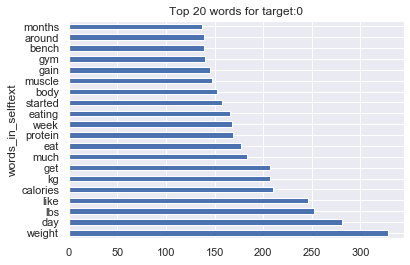

In [32]:
# display top words and corresponding frequecy for target 0
common_words_0 = get_top_n_words(clean_selftext_target0, 20)
for word, freq in common_words_0:
    print(word, freq)
df0 = pd.DataFrame(common_words_0, columns = ['words_in_selftext' , 'count'])
df0.groupby('words_in_selftext').sum()['count'].sort_values(ascending=False).plot(
    kind='barh', title='Top 20 words for target:0');




In [33]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:20]

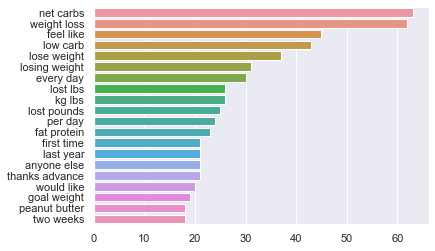

In [34]:
# display top bigrams and corresponding frequecy for target 1
top_n_bigrams_1=get_top_ngram(clean_selftext_target1,2)[:20]
x,y=map(list,zip(*top_n_bigrams_1))
sns.barplot(x=y,y=x);

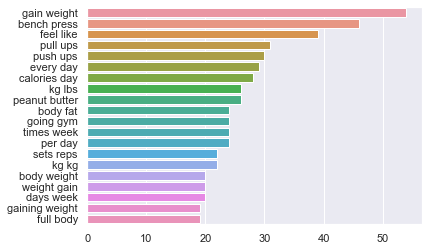

In [35]:
# display top bigrams and corresponding frequecy for target 0
top_n_bigrams_0=get_top_ngram(clean_selftext_target0,2)[:20]
x,y=map(list,zip(*top_n_bigrams_0))
sns.barplot(x=y,y=x);

A train dataset to train the model and test dataset test the model is obtained by train/test split of the dataset.

Shuffling the data serves the purpose of reducing variance and making sure that models remain general and overfit less. This ensures that the  train/test sets are representative of the overall distribution of the data.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(combined_df[['selftext']],
                                                    combined_df['target'],
                                                    test_size = 0.25,
                                                    stratify = combined_df['target'],shuffle=True,random_state=42)

In [37]:
total_selftext = combined_df.shape[0]
total_selftext

960

In [38]:
print(f'There are {total_selftext} reviews.')

# Initialize an empty list to hold the clean reviews.
clean_train_selftext = []
clean_test_selftext = []

There are 960 reviews.


In [39]:
print("Cleaning and parsing the training set posts...")

# Instantiate counter.
j = 0
i = 0
# For every review in our training set...
for train_selftext in X_train['selftext']:
    
    # Convert review to words, then append to clean_train_selftext.
    clean_train_selftext.append(text_to_words(train_selftext))
    
    # If the index is divisible by 100, print a message.
    if (j + 1) % 100 == 0:
        print(f'Review {j + 1} of {total_selftext}.')
    
    j += 1

# Let's do the same for our testing set.
print("Cleaning and parsing the testing set posts...")

# For every review in our testing set...
for test_selftext in X_test['selftext']:
    
    # Convert review to words, then append to clean_test_selftext.
    clean_test_selftext.append(text_to_words(test_selftext))
    
    # If the index is divisible by 100, print a message.
    if (i + 1) % 100 == 0:
        print(f'Review {i + 1} of {total_selftext}.')
        
    i += 1




Cleaning and parsing the training set posts...
Review 100 of 960.
Review 200 of 960.
Review 300 of 960.
Review 400 of 960.
Review 500 of 960.
Review 600 of 960.
Review 700 of 960.
Cleaning and parsing the testing set posts...
Review 100 of 960.
Review 200 of 960.


## Model Prep

The two models selected are the Naive Bayes Classifier,of which the one most suitable for text is the multinomial variant.and Logistic Regression model. A pipeline is created for each model, varying the vectorizer for each. The table below shows the training and testing accuracy score for each model. Some of the hyperparameters that were considered for tuning included:
1. max_df
    - Consider words that occur in at most 90 or 95% of the documents.Words occuring in greater than the chosen values of documents  might not be very informative.
2. min_df
    - A word must occur in at least 2 or 3 documents from the corpus.
Tuning these parameters can help to reduce the impact of outliers on the model.




In [40]:
def lr_model_evaluation(transformer):
    if transformer == 'cvec':
        pipe = Pipeline([
        ('cvec', CountVectorizer()),
        ('logreg', LogisticRegression(solver='liblinear',max_iter=200))

    ])
        pipe_params = {
        'cvec__max_features' :[1000,2000, 3000],
        'cvec__min_df':[2,3],
        'cvec__max_df':[0.9,0.95],
        'cvec__ngram_range': [(1, 1),(1, 2),(1, 3)],
        'logreg__C': [0.01, 0.1, 1, 10],
        'logreg__class_weight':[None, 'balanced'],
        'logreg__penalty': ['l1', 'l2']
    }
    elif transformer == 'tvec':
        pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logreg', LogisticRegression(solver='liblinear',max_iter=200))
    
])
        pipe_params = {
    'tvec__max_features' :[1000, 2000,3000],
    'tvec__min_df':[2,3],
    'tvec__max_df':[0.9,0.95],
    'tvec__ngram_range': [(1, 1),(1, 2),(1, 3)],
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__class_weight':[None, 'balanced'],
    'logreg__penalty': ['l1', 'l2']
}
    gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid = pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation. 
    
    gs.fit(clean_train_selftext,y_train)
    gs_model = gs.best_estimator_
    #print(f'Train score = {gs_model.score(clean_train_selftext, y_train)}')
    #print(f'Test score = {gs_model.score(clean_test_selftext, y_test)}')
    print(f'Best params = {gs.best_params_}')
    

In [41]:
def lr_accuracy_scores(vectorizer,C_value,class_weight,penalty):
    train_data_features = vectorizer.fit_transform(clean_train_selftext)

    test_data_features = vectorizer.transform(clean_test_selftext)
    logit = LogisticRegression(C = C_value,
                           class_weight = class_weight,
                           penalty = penalty)
    logit.fit(X = train_data_features,
          y = y_train)
    print(f'Train score = {logit.score(train_data_features, y_train)}')
    print(f'Test score = {logit.score(test_data_features, y_test)}')
    return(logit,test_data_features)

In [42]:
def nb_model_evaluation(transformer):
    if transformer == 'cvec':
        pipe = Pipeline([
        ('cvec', CountVectorizer()),
        ('nb', MultinomialNB())

    ])
        pipe_params = {
        'cvec__max_features' :[1000,2000,3000],
        'cvec__min_df':[2,3],
        'cvec__max_df':[0.9,0.95],
        'cvec__ngram_range': [(1, 1),(1, 2),(1, 3)],
        'nb__fit_prior':[True,False]
    }
    elif transformer == 'tvec':
        pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
    
])
        pipe_params = {
    'tvec__max_features' :[1000,2000,3000],
    'tvec__min_df':[2,3],
    'tvec__max_df':[0.9,0.95],
    'tvec__ngram_range': [(1, 1),(1, 2),(1, 3)],
    'nb__fit_prior':[True,False]
}
    gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid = pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation. 
    
    gs.fit(clean_train_selftext,y_train)
    gs_model = gs.best_estimator_
    #print(f'Train score = {gs_model.score(clean_train_selftext, y_train)}')
    #print(f'Test score = {gs_model.score(clean_test_selftext, y_test)}')
    print(f'Best params = {gs.best_params_}')
    

In [43]:
def nb_accuracy_scores(vectorizer,fit_prior_value):
    train_data_features = vectorizer.fit_transform(clean_train_selftext)

    test_data_features = vectorizer.transform(clean_test_selftext)
    nb = MultinomialNB(fit_prior = fit_prior_value)
    nb.fit(X = train_data_features,
          y = y_train)
    print(f'Train score = {nb.score(train_data_features, y_train)}')
    print(f'Test score = {nb.score(test_data_features, y_test)}')
    return (nb,test_data_features)

In [44]:
lr_model_evaluation('cvec')

#### Best params obtained for:
1. Vectorizer - CountVectorizer
2. Classification - Logistic Regression

Best params = {'cvec__max_df': 0.9, 'cvec__max_features': 1000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'logreg__C': 0.01, 'logreg__class_weight': None, 'logreg__penalty': 'l2'}

In [45]:
lr_model_evaluation('tvec')

#### Best params obtained for:
1. Vectorizer - TfidfVectorizer
2. Classification - Logistic Regression

Best params = {'logreg__C': 1, 'logreg__class_weight': 'balanced', 'logreg__penalty': 'l2', 'tvec__max_df': 0.9, 'tvec__max_features': 3000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}

In [46]:
nb_model_evaluation('cvec')

#### Best params obtained for:
1. Vectorizer - CountVectorizer
2. Classification - MultinomialNB

Best params = {'cvec__max_df': 0.9, 'cvec__max_features': 3000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 3), 'nb__fit_prior': False}

In [47]:
nb_model_evaluation('tvec')

#### Best params obtained for:
1. Vectorizer - TfidfVectorizer
2. Classification - MultinomialNB

Best params = {'nb__fit_prior': False, 'tvec__max_df': 0.9, 'tvec__max_features': 2000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}

## Model fit and evaluation

Of the 4 models, the logistic regression model fitted with features extracted from unstructured text by fitting and transforming with `TfidfVectorizer` performed the best across the train and test dataset.




The metrics: accuracy, precision, f1-score and ROC AUC score is used to identify the best model. With `penalty = 'l2'` indicating the L2 or Ridge penalty and `C = 1.0` indicating that the inverse of the regularization strength is 1. $C = \frac{1}{\alpha} \Rightarrow 1 = \frac{1}{\alpha} \Rightarrow \alpha = 1$. The accuracy metric is chosen as the classes are approximately balanced and each class is equally important. The accuracy score was 98.7% on training data and 90.4% on unseen data. This means that the model is overfitted and that 90.4% of the posts will be accurately classified by the model. The results are significantly better than baseline.




|        Model        |    value of fit_prior   | Penalty |   Hyperparameter   | Training Accuracy | Testing Accuracy |Vectorizer |
|:-------------------:|:--------------:|:-------:|:----------:|:-----------------:|:----------------:|:----------------:|
|         MultinomialNB         |  False |    NA   |      $\alpha = 1$     |       0.967      |      0.896     |CountVectorizer|
|         MultinomialNB         |  False |    NA   |      $\alpha = 1$     |       0.963      |      0.892      |TfidfVectorizer|
| logistic regression |   NA   |  Ridge  |   $C$ = 1 |       0.988      |      0.904      |TfidfVectorizer|
| logistic regression |   NA   |  Ridge  | $C$ = 0.01 |       0.947      |      0.892      |CountVectorizer|

In [48]:
cvec_Lr = CountVectorizer(max_features=1000,ngram_range=(1,2),max_df=0.9,min_df=2)
lr_cvec,test_data_features_lr_cvec =lr_accuracy_scores(cvec_Lr,0.01,None,'l2')

Train score = 0.9472222222222222
Test score = 0.8916666666666667


In [49]:
tvec_Lr = TfidfVectorizer(max_features=3000,ngram_range=(1,2),max_df=0.9,min_df=2)
lr_tvec,test_data_features_lr_tvec =lr_accuracy_scores(tvec_Lr,1,'balanced','l2')

Train score = 0.9875
Test score = 0.9041666666666667


In [50]:
cvec_Nb = CountVectorizer(max_features=3000,ngram_range=(1,3),max_df=0.9,min_df=2)
nb_cvec,test_data_features_nb_cvec = nb_accuracy_scores(cvec_Nb,False)

Train score = 0.9666666666666667
Test score = 0.8958333333333334


In [51]:
tvec_Nb = TfidfVectorizer(max_features=2000,ngram_range=(1,2),max_df=0.9,min_df=2)
nb_tvec,test_data_features_nb_tvec = nb_accuracy_scores(tvec_Nb,False)

Train score = 0.9625
Test score = 0.8916666666666667


The TF-IDF Vectorizer identifies which words are important to one document, relative to all other documents. Words that occur often in one document but don't occur in many documents contain more predictive power and are identified by the vectorizer. Logistic regression has traditionally been used to come up with a hyperplane that separates the feature space into classes and typically works reasonably well even when some of the variables are correlated. In contrast, Naive Bayes assumes that the features are conditionally independent. Real data sets are never perfectly independent but they can be close.

Research has shown that when the training size reaches infinity the discriminative model: logistic regression performs better than the generative model Naive Bayes(Ng and Jordan,2002).



AUC - ROC curve is a performance measurement for classification problem at various thresholds settings.It tells how much a model is capable of distinguishing between classes. An excellent model has AUC near to the value of 1 which means it has good measure of separability. 

Abbreviations used:
- TPR(True Positive Rate)/Recall/Sensitivity = TP / (TP + FN)
- Specificity = TN / (TN + FP)
- Precision = TP/(TP + FP)
- FPR = 1 - Specificity 

When 2 distributions overlap, type 1 and 2 error are introduced. Sensitivity and Specificity are inversely proportional to each other. When the threshold is decreased, sensitivity(TPR) increases and specificity decrease. As FPR = 1 - Specificity, when TPR increase, FPR also increases.


In [52]:
pred_proba_nb_cvec = [i[1] for i in nb_cvec.predict_proba(test_data_features_nb_cvec)]
pred_df_nb_cvec = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba_nb_cvec})

In [53]:
# ROC AUC 
# 1. Vectorizer - CountVectorizer
# 2. Classification - MultinomialNB
roc_auc_score(pred_df_nb_cvec['true_values'], pred_df_nb_cvec['pred_probs'])

0.9614849833147943

In [54]:
pred_proba_nb_tvec = [i[1] for i in nb_tvec.predict_proba(test_data_features_nb_tvec)]
pred_df_nb_tvec = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba_nb_tvec})

In [55]:
# ROC AUC 
# 1. Vectorizer - TfidfVectorizer
# 2. Classification - MultinomialNB
roc_auc_score(pred_df_nb_tvec['true_values'], pred_df_nb_tvec['pred_probs'])

0.9635011123470523

In [56]:
pred_proba_lr_cvec = [i[1] for i in lr_cvec.predict_proba(test_data_features_lr_cvec)]
pred_df_lr_cvec = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba_lr_cvec})

In [57]:
# ROC AUC 
# 1. Vectorizer - CountVectorizer
# 2. Classification - Logistic Regression
roc_auc_score(pred_df_lr_cvec['true_values'], pred_df_lr_cvec['pred_probs'])

0.9533509454949944

In [58]:
pred_proba = [i[1] for i in lr_tvec.predict_proba(test_data_features_lr_tvec)]
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

In [59]:
# ROC AUC 
# 1. Vectorizer - TfidfVectorizer
# 2. Classification - Logistic Regression
roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

0.9655867630700778

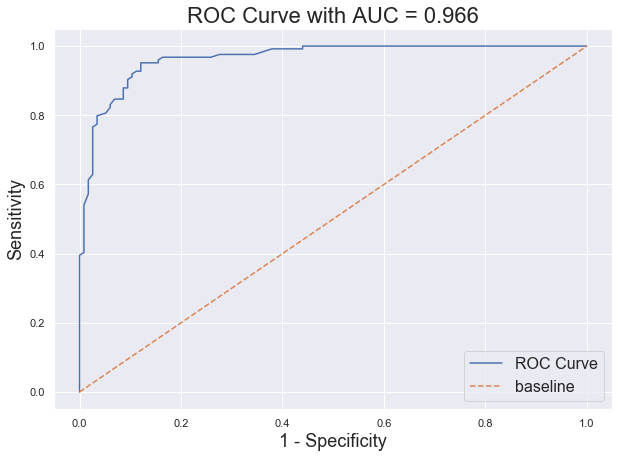

In [60]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

An ROC AUC of 0.966 indicates that the positive and negative populations are well separated.

The precision,sensitivity and f1-scores can be analysed by generating a classification report.

For purpose of analysis in this binary classification problem, the **positive** class aka target class 1 will be used as the reference class to be detected. 

The *precision* for target class 1 is the number of correctly predicted posts out of all predicted target class 1 posts.
The logistic regression classifier performed better and 87% of the posts that that was predicted as target class 1 is actually a target class 1 post.

The *recall* for target class 1 is the number of correctly predicted target class 1 posts out of the number of actual target class 1 posts. The naive bayes classifier performed better and 96% of the target class 1 posts were classified as target class 1 posts.

Since the logistic regression classifier has a better precision score and naive bayes has a better recall score, 
the *F1-score* can be used to summarize the models’ performance into a single metric. The harmonic mean is calculated by giving weight to lower numbers. Out of the four models, the logistic regression model fitted with features extracted from unstructured text by fitting and transforming with `TfidfVectorizer` had the highest *F1-score*.

The relative importance assigned to precision and recall should be an aspect of the problem as different prediction errors have different implications. However, in the context of the problem to be solved, incorrectly classifying a keto post as a gainit post doesn't seem much better or worse than incorrectly mistaking a gainit post for a keto post and the *F1-score* will be taken into consideration.



In [61]:
# classfication report 
# 1. Vectorizer - CountVectorizer
# 2. Classification - Logistic Regression
predictions_lr_cvec = lr_cvec.predict(test_data_features_lr_cvec)
print(classification_report(y_test,
                            predictions_lr_cvec))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88       116
           1       0.87      0.93      0.90       124

    accuracy                           0.89       240
   macro avg       0.89      0.89      0.89       240
weighted avg       0.89      0.89      0.89       240



In [62]:
# classfication report 
# 1. Vectorizer - TfidfVectorizer
# 2. Classification - Logistic Regression
predictions_lr_tvec = lr_tvec.predict(test_data_features_lr_tvec)
print(classification_report(y_test,
                            predictions_lr_tvec))

              precision    recall  f1-score   support

           0       0.94      0.85      0.90       116
           1       0.87      0.95      0.91       124

    accuracy                           0.90       240
   macro avg       0.91      0.90      0.90       240
weighted avg       0.91      0.90      0.90       240



In [63]:
# classfication report 
# 1. Vectorizer - CountVectorizer
# 2. Classification - MultinomialNB
predictions_nb_cvec = nb_cvec.predict(test_data_features_nb_cvec)
print(classification_report(y_test,
                            predictions_nb_cvec))

              precision    recall  f1-score   support

           0       0.95      0.83      0.88       116
           1       0.86      0.96      0.90       124

    accuracy                           0.90       240
   macro avg       0.90      0.89      0.89       240
weighted avg       0.90      0.90      0.90       240



In [64]:
# classfication report 
# 1. Vectorizer - TfidfVectorizer
# 2. Classification - MultinomialNB
predictions_nb_tvec = nb_tvec.predict(test_data_features_nb_tvec)
print(classification_report(y_test,
                            predictions_nb_tvec))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88       116
           1       0.85      0.96      0.90       124

    accuracy                           0.89       240
   macro avg       0.90      0.89      0.89       240
weighted avg       0.90      0.89      0.89       240



## Business Recommendations

Taking into consideration the various metrics, the logistic regression model fitted with features extracted from unstructured text by fitting and transforming with `TfidfVectorizer` performed the best.

In [65]:
X_test_df = pd.DataFrame(test_data_features_lr_tvec.toarray(),
                         columns=tvec_Lr.get_feature_names())

In [66]:
zipped= list(zip(X_test_df.columns,np.exp(lr_tvec.coef_[0])))

The coefficients in a logistic regression model are interpretable. (They represent the change in log-odds caused by the input variables.) This might be of interest to advertisors seeking to sell their products targetted for a particular subreddit. By identifying what the community on the subreddit is most concerned about can result in more effective marketing.

Interpreting the coefficent of 2 of the features: As the occurance of the bi-gram 'weight loss' increases by one unit , the document is 2.88 times as likely to be from the keto subreddit, all else held equal.
As the occurance of the feature 'carbs' increases by one unit , the document is 12.26 times as likely to be from the keto subreddit, all else held equal.

Advertisors can harness insights from data analytics and gather that the community in general are concerned about reducing the net carb intake and develop marketing strategies accordingly.

In [67]:
zipped.sort(key = lambda t: t[1],reverse=True)
zipped[:20]

[('carbs', 12.26241662938849),
 ('diet', 6.173476240153748),
 ('lost', 3.719794524423096),
 ('carb', 3.5798484368027714),
 ('loss', 3.2857299583929236),
 ('net', 2.9122274459752115),
 ('weight loss', 2.887377820367173),
 ('sugar', 2.8720463504916385),
 ('sis', 2.808546061561927),
 ('macros', 2.51207506006517),
 ('net carbs', 2.4353711344093765),
 ('meat', 2.396066460427404),
 ('losing', 2.2835952629489156),
 ('weeks', 2.2807224667240042),
 ('lose', 2.2653635448764775),
 ('life', 2.2177463100711554),
 ('hello', 2.177322141781894),
 ('starting', 2.0806089239601557),
 ('cw', 2.076612747829489),
 ('friendly', 2.0500801330888816)]

In [68]:
zipped2= list(zip(X_test_df.columns,lr_tvec.coef_[0]))

In [69]:
zipped2.sort(key = lambda t: t[1],reverse=False)
zipped2[:30]

[('gain', -2.164055651319042),
 ('gym', -1.8043830682591242),
 ('muscle', -1.6714941975409274),
 ('bench', -1.5975581884069319),
 ('skinny', -1.431105118232352),
 ('sets', -1.415879182687912),
 ('workout', -1.3288553255863769),
 ('kg', -1.2471710271414866),
 ('exercises', -1.243710327257744),
 ('gains', -1.183284088142137),
 ('bulk', -1.0044328800801847),
 ('gain weight', -1.0026205688514613),
 ('reps', -0.9364517907909264),
 ('calories', -0.9308752833833317),
 ('strength', -0.8904193387365049),
 ('pull', -0.8541079580934536),
 ('program', -0.8520298456393514),
 ('ups', -0.8483888575190334),
 ('lifting', -0.8353251594706743),
 ('arms', -0.8243137305728138),
 ('shake', -0.8156982461055055),
 ('gaining', -0.7979007408336954),
 ('squat', -0.7962530720382635),
 ('ppl', -0.7824759924932201),
 ('creatine', -0.7813935903264702),
 ('bar', -0.7643211940169845),
 ('home', -0.7640847807056449),
 ('working', -0.7431121330250435),
 ('lifts', -0.7405611276983136),
 ('barbell', -0.7347650788133809)]

To understand how the model can be further improved, some insights can be drawn from the misclassified posts. True positives in this context are posts correctly predicted as posts from the /keto subreddit while true negatives are posts correctly predicted as posts from the /gainit subreddit. There are a total of 17 posts misclassified as false positives and 6 posts misclassified as false negatives.

In [70]:
confusion_matrix(y_test, predictions_lr_tvec)

array([[ 99,  17],
       [  6, 118]])

In [71]:
#Identifying the posts that are misclassified
tn, fp, fn, tp = confusion_matrix(y_test, predictions_lr_tvec).ravel()

In [72]:
print("True Negatives: " + str(tn))
print()
print("False Positives: " + str(fp))
print()
print("False Negatives: " + str(fn))
print()
print("True Positives: " + str(tp))

True Negatives: 99

False Positives: 17

False Negatives: 6

True Positives: 118


In [73]:
#Identifying posts that are misclassified as posts from r/keto
check_df = pd.DataFrame({'target': list(y_test), 'prediction': predictions_lr_tvec, 'text':list(clean_test_selftext)})

check_false_positive = check_df.loc[(check_df['target']!=check_df['prediction'])&(check_df['target']==0)&(check_df['prediction']==1),:]
check_false_positive



,target,prediction,text
7,0,1,substances invoke strong apettite responses tr...
13,0,1,advice appreciated thanks much
37,0,1,discovered pop tarts calories individual pack ...
46,0,1,assuming performing intensity volumes could al...
62,0,1,hello everyone calculating meals according mac...
73,0,1,hi wondering anyone nut rich diet digestive ga...
75,0,1,may wrong place ask anyone protein brownie rec...
93,0,1,seems must eat around cals gain weight often i...
107,0,1,eye either want make sure choosing well thanks
128,0,1,really long uh venting rambling sort thing fee...


In [74]:
#Identifying posts that are misclassified as posts from r/gainit
check_false_negative = check_df.loc[(check_df['target']!=check_df['prediction'])&(check_df['target']==1)&(check_df['prediction']==0),:]
check_false_negative

,target,prediction,text
20,1,0,starting nicer midwest likely going start ridi...
130,1,0,went ish little bit looks different see big ch...
134,1,0,skinny fat love handles chin exist overall yik...
148,1,0,trying lose weight quarantine school year gain...
160,1,0,supposed eat calories loose weight supposed al...
193,1,0,weight always yoyo ed lbs tired due shorter wo...


In [75]:
clean_selftext_fn = []
clean_self_text_fn_str = ' '
clean_selftext_fp = []
clean_self_text_fp_str = ' '
print("Cleaning and parsing the selftext...")

# Instantiate counter.
j = 0

# For every false positive selftext
for selftext in check_false_positive['text']:
    
    clean_self_text_fp_str = clean_self_text_fp_str + text_to_words(selftext) + ' '
    # Convert review to words, then append to clean_train_selftext.
    clean_selftext_fp.append(text_to_words(selftext))
    
    j += 1

# For every false negative selftext
for selftext in check_false_negative['text']:
    
    clean_self_text_fn_str = clean_self_text_fn_str + text_to_words(selftext) + ' '
    # Convert review to words, then append to clean_train_selftext.
    clean_selftext_fn.append(text_to_words(selftext))
    
    j += 1

Cleaning and parsing the selftext...


The posts that were misclassified to be from target class 1 contained features like 'carbs' which as established earlier, as the occurance of the feature 'carbs' increases by one unit , the document is 12.26 times as likely to be from the keto subreddit, all else held equal. This could have attributed in the posts being misclassified.

As there is evidence of overfitting, futher attempts can be made to gather more data to reduce variance.

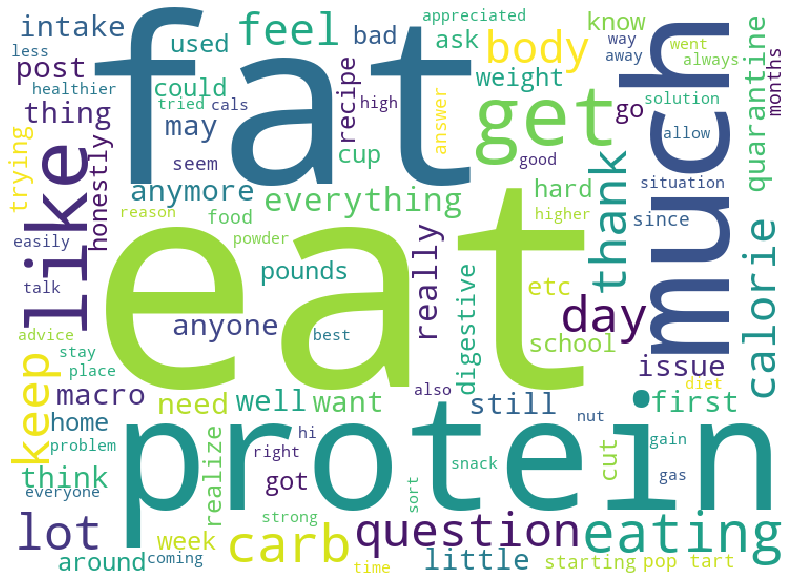

In [76]:
#Word cloud generated for false positive posts
wc3 = WordCloud(max_words= 100,
                      width = 744, 
                      height = 544,
                      background_color ='white',
                      stopwords=stops, 
                      contour_width=3, 
                      contour_color='steelblue',
                      min_font_size = 10).generate(clean_self_text_fp_str) 
  
# plot the WordCloud image                        
plt.figure(figsize = (14, 14)) 
plt.imshow(wc3) 
plt.axis("off")
plt.savefig('../images/reddit_wordcloud_selftext_fp.png')

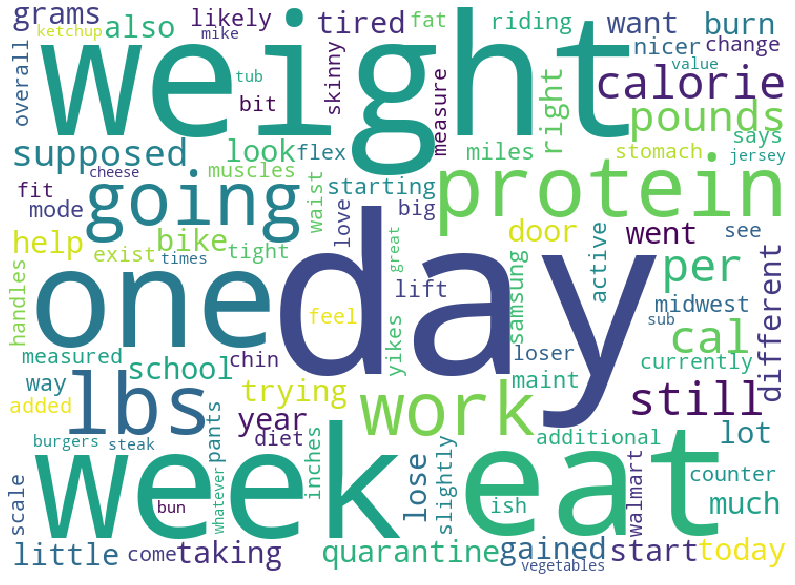

In [77]:
#Word cloud generated for false negative posts
wc3 = WordCloud(max_words= 100,
                      width = 744, 
                      height = 544,
                      background_color ='white',
                      stopwords=stops, 
                      contour_width=3, 
                      contour_color='steelblue',
                      min_font_size = 10).generate(clean_self_text_fn_str) 
  
# plot the WordCloud image                        
plt.figure(figsize = (14, 14)) 
plt.imshow(wc3) 
plt.axis("off")
plt.savefig('../images/reddit_wordcloud_selftext_fn.png')

eat 14
protein 12
much 10
get 10
like 10
eating 9
fat 9
keep 7
thanks 6
carbs 6
body 6
calories 5
fats 5
everything 5
lot 5
day 5
really 5
feel 5
quarantine 4
still 4


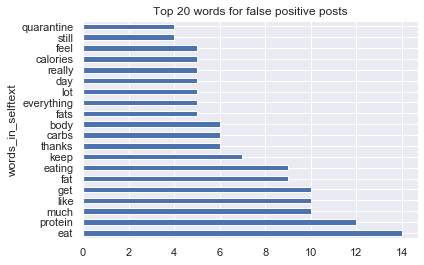

In [78]:
#uni-gram of false positive posts
common_words_fp = get_top_n_words(clean_selftext_fp, 20)
word_list_fp=[]
for word, freq in common_words_fp:
    print(word, freq)
    word_list_fp.append(word)
df_fp = pd.DataFrame(common_words_fp, columns = ['words_in_selftext' , 'count'])
df_fp.groupby('words_in_selftext').sum()['count'].sort_values(ascending=False).plot(
    kind='barh', title='Top 20 words for false positive posts');

day 8
weight 6
week 5
eat 5
one 4
protein 4
lbs 4
going 3
work 3
days 3
per 3
still 3
pounds 3
supposed 3
start 2
bike 2
door 2
taking 2
calories 2
burn 2


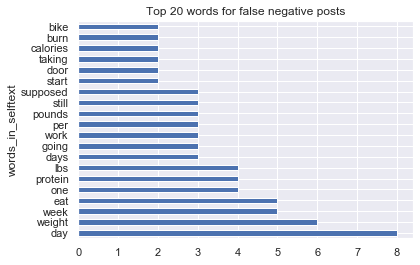

In [79]:
#uni-gram of false negative posts
common_words_fn = get_top_n_words(clean_selftext_fn, 20)
word_list_fn=[]
for word, freq in common_words_fn:
    print(word, freq)
    word_list_fn.append(word)
df_fn = pd.DataFrame(common_words_fn, columns = ['words_in_selftext' , 'count'])
df_fn.groupby('words_in_selftext').sum()['count'].sort_values(ascending=False).plot(
    kind='barh', title='Top 20 words for false negative posts');

## Sources

**Ng and Jordan**. 2002. On Discriminative vs Generative classifers: A comparision of logistic regression and naive Bayes http://ai.stanford.edu/~ang/papers/nips01-discriminativegenerative.pdf